In [1]:
# Import packages
import numpy as np
import pandas as pd
from tifffile import imread
from matplotlib import pyplot as plt
import seaborn as sns
from skimage.measure import regionprops_table

In [2]:
# Define I/O paths
path_input = "../../Input/Data/puncta_fluorescence/20221201_sd_nikon_sr/"
path_output = "../../Output/"
path_puncta = path_output+"Spots/"
path_segmentation = path_output+"Segmentation/Auxin_1_w1SPI 405 DAPI_cellpose_segmentation/"

In [3]:
# Read data
nuc_labels = imread(path_segmentation+'curated_labels2.tif')
spots = np.load(path_puncta+"spots.npy")

# Define voxel size
voxel_size = (200, 110, 110) # in nanometers
voxel_volume_nm = voxel_size[0] * voxel_size[1] * voxel_size[2]
voxel_volume_um = voxel_volume_nm / 1e9 # in micrometers

In [4]:
# Make dataframe from array
df_spots = pd.DataFrame(spots, columns=['z','y','x'])
# Assign to each spot a label (0 for bg or nucleus label)
df_spots['label'] = nuc_labels[spots[:,0],spots[:,1],spots[:,2]]
# Calculate volume for each nucleus
props = pd.DataFrame(regionprops_table(nuc_labels, properties=['label','area']))

# Create stats dataframe
df_stats = (df_spots
    .groupby('label')
    .count() # count how many spots there are for each label
    .reset_index()
    .merge(props, on='label', how='left') # keep track of volume for each nucleus
    .drop(columns = ['y','z']) # drop duplicate info
    .rename(columns = {'x':'num_spots', 'area':'volume'}) # give more accurate names
    .assign(volume_um3 = lambda df_: df_.volume * voxel_volume_um) # convert volume to micrometer^3
    .assign(spots_per_volume = lambda df_: df_.num_spots / df_.volume_um3) # calculate relative number of spots per volume
)

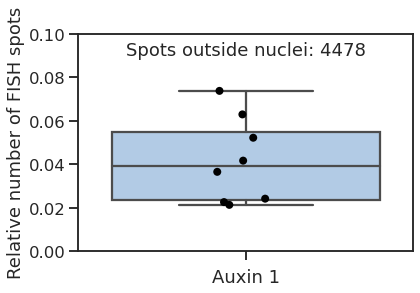

In [5]:
sns.set(style='ticks', context='talk')
g = sns.boxplot(data=df_stats, y='spots_per_volume', boxprops={"facecolor": (.4, .6, .8, .5)})
sns.stripplot(data=df_stats, y='spots_per_volume', size=8, color='black')
g.set(xlabel='Auxin 1', ylabel='Relative number of FISH spots', ylim=(0,0.1))
plt.text(x=0.5, y=0.9, s='Spots outside nuclei: {}'.format(df_stats[df_stats.label == 0].num_spots.values[0]), 
        transform = g.axes.transAxes,
        ha = 'center')
plt.show()